###### ### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2021 Semester 1

## Assignment 1: Pose classification with naive Bayes


**Student ID(s):**     `PLEASE ENTER YOUR ID(S) HERE`


This iPython notebook is a template which you will use for your Assignment 1 submission.

Marking will be applied on the four functions that are defined in this notebook, and to your responses to the questions at the end of this notebook (Submitted in a separate PDF file).

**NOTE: YOU SHOULD ADD YOUR RESULTS, DIAGRAMS AND IMAGES FROM YOUR OBSERVATIONS IN THIS FILE TO YOUR REPORT (the PDF file).**

You may change the prototypes of these functions, and you may write other functions, according to your requirements. We would appreciate it if the required functions were prominent/easy to find.

**Adding proper comments to your code is MANDATORY. **

In [27]:
# This function should prepare the data by reading it from a file and converting it into a useful format for training and testing

import numpy as np
from collections import defaultdict
import re
from math import sqrt
from math import exp
from math import pow
from math import pi
from math import log
import matplotlib.pyplot as plt
%matplotlib inline

# open & store data from training file
def open_train_file(train_attr_vals, train_classes,filename):
    f = open(filename,'r')
    
    for line in f.readlines()[0:]:
        cleaned_line = line.strip().split(",")
        attributes = cleaned_line[1:]
        class_name = cleaned_line[0]
        train_attr_vals.append(attributes)
        train_classes.append(class_name)
    f.close
    return 

#impute missing values from 9999 to 0 
def remove_missing_values(train_attr_vals):
    
    for instance in train_attr_vals:
        for i in range(len(instance)):
            if(instance[i]==9999):
                instance[i]=0          
    return

#convert elements in array from string to float                
def str_to_float(train_attr_vals):
    for instance in train_attr_vals:
        for i in range(len(instance)):
                instance[i]=float(instance[i])
    return 

def put_into_dict(train_attr_vals,train_classes,class_dict,class_count_dict):
    instance_num = len(train_attr_vals)
    
    for i in range(instance_num):
        attributes = train_attr_vals[i]
        class_name = train_classes[i]
        if class_dict.get(class_name) is None:
            class_dict[class_name]=[]
        # appending each
        class_dict[class_name].append(attributes)
        class_count_dict[class_name] += 1
    return class_dict, class_count_dict
    
def preprocess(train_attr_vals, train_classes, class_dict, class_count_dict, train_filename):
    
    #train_filename = "COMP30027_2021_assignment1_data/train.csv"
    # open training file and store into arrays
    open_train_file(train_attr_vals, train_classes,train_filename)
    
    # change string to float values
    str_to_float(train_attr_vals)
    
    # impute missing values
    remove_missing_values(train_attr_vals)
    
    # put instances into dictionary based on classes
    put_into_dict(train_attr_vals,train_classes,class_dict,class_count_dict)
    
    return 


In [28]:
# This function should calculate prior probabilities and likelihoods from the training data and using
# them to build a naive Bayes model

def mean(array):
    return (sum(array)/len(array))

def standard_deviation(array,mean_val):
    total = 0
    for one in array:
        total+=(pow((one-mean_val),2))
    result = sqrt(total/(len(array)-1))
    return result

def train(class_dict, class_count_dict,training_details,attr_length,total_inst):
    
    # dictionary format {key : [[means], [standard deviation], class_prob]}
    for key in class_dict.keys():
        
        if training_details.get(key) is None:
            training_details[key]=[]
            
        #array to store each attributes' mean value
        mean_array=[]
        
        #array to store each standard deviations' value
        std_dev_array=[]
        
        for i in range(attr_length):
            attr_array = [instance[i] for instance in class_dict[key]]
            
            mean_val = mean(attr_array)
            std_dev_val = standard_deviation(attr_array,mean_val) 
            
            mean_array.append(mean_val)
            std_dev_array.append(std_dev_val)
            
        #append mean, standard deviation & class probability to training details dictionary
        training_details[key].append(mean_array)
        training_details[key].append(std_dev_array)
        class_prob = class_count_dict[key]/total_inst
        training_details[key].append(class_prob)
        
    return


In [29]:
# This function should predict classes for new items in a test dataset (for the purposes of this assignment, you
# can re-use the training data as a test set)

def gaussian_distribution(val,mean,std_dev):
    exponential = exp(-(1/2)* (pow(((val-mean)/std_dev),2)))
    result = (1/(std_dev * sqrt(2*pi)))* exponential
    return result

def take_log(val):
    if(val==0):
        return 0
    else:
        return log(val)

def probability(instance,training_details,attr_num,class_num):
    probs = defaultdict()
    
    #find the likelihood/probability of the instance in each class
    for key in training_details.keys():
        total_prob=0
        sum_gaussian_prob=0
        
        # likelihood of the instance's attribute based on the class
        for i in range(attr_num):
            attr_mean = training_details[key][0][i]
            attr_std_dev = training_details[key][1][i]
            
            gauss_prob = gaussian_distribution(instance[i],attr_mean,attr_std_dev)
            #take_log here to handle log(0) for now as log(0) cant be computed
            sum_gaussian_prob+=take_log(gauss_prob)
            
        # probability of the instance being a class :  log(class prob) + sum(log(each attribute))
        total_prob+=sum_gaussian_prob
        class_prob=training_details[key][2]
        total_prob+=log(class_prob)
        
        # put in dictionary
        probs[key] = total_prob

    return probs
            
def predict(training_details,attr_num,class_num,test_attr_vals,test_actual_class, test_filename):
    
    # open testing file & store data
    open_train_file(test_attr_vals,test_actual_class,test_filename)
    str_to_float(test_attr_vals)
    remove_missing_values(test_attr_vals)
    
    predicted_classes=[]
    for instance in test_attr_vals:
        # dictionary to store the probability 
        # of each instances being classified as each classes
        probability_dict = probability(instance,training_details,attr_num,class_num)
        
        #find the class with the highest probability
        max_prob_class = max(probability_dict, key=probability_dict.get)
        predicted_classes.append(max_prob_class)
    
    return predicted_classes


In [30]:
# This function should evaluate the prediction performance by comparing your model’s class outputs to ground
# truth labels

def evaluate(test_actual_class,predicted_classes):    
        
    correct_label = 0
    test_num=len(test_actual_class)
    for i in range(test_num):
        if(test_actual_class[i]==predicted_classes[i]):
            correct_label+=1

    accuracy = (correct_label / test_num) * 100
    print(accuracy)
    return accuracy



In [31]:
#RUN HERE
#store value of attributes of each instance
train_attr_vals = []

#store class of training isntances
train_classes = []

#class_dict : store all instances per class 
class_dict = defaultdict()

#class_count_dict: store number of instances per class
class_count_dict = defaultdict(int)

#store the details of each class after training
training_details = defaultdict()

#number of attributes
attr_num = 0

#number of instances
total_instances = 0

#open training file
train_filename = "COMP30027_2021_assignment1_data/train.csv"

#class_dict : store all instances per class & class_count_dict: store number of instances per class
preprocess(train_attr_vals, train_classes, class_dict, class_count_dict, train_filename)

#number of attributes
attr_num = len(train_attr_vals[0])

total_instances = sum([class_count_dict[key] for key in class_count_dict.keys()])

#train the data
#result is training_details dict format - {class_name : [[means], [standard deviation], class_prob]}
train(class_dict, class_count_dict, training_details, attr_num, total_instances)

#open test file
test_filename="COMP30027_2021_assignment1_data/test.csv"

# store values of testing instances
test_attr_vals=[]

# store actual class of testing instances
test_actual_class=[]

# predicted classes of the testing instances
predicted_classes = predict(training_details,attr_num,len(training_details.keys()),test_attr_vals,test_actual_class, test_filename)

accuracy = evaluate(test_actual_class,predicted_classes)
print("Accuracy is ", accuracy,"%")


73.27586206896551
Accuracy is  73.27586206896551 %


## Questions 


If you are in a group of 1, you will respond to **two** questions of your choosing.

If you are in a group of 2, you will respond to **four** questions of your choosing.

A response to a question should take about 100–250 words, and make reference to the data wherever possible.

#### NOTE: you may develope codes or functions to help respond to the question here, but your formal answer should be submitted separately as a PDF.

### Q1
Since this is a multiclass classification problem, there are multiple ways to compute precision, recall, and F-score for this classifier. Implement at least two of the methods from the "Model Evaluation" lecture and discuss any differences between them. (The implementation should be your own and should not just call a pre-existing function.)

In [32]:
#try macro averaging vs micro averaging

#set values back to zero
def set_to_zero(tp, tn, fn, fp):
    tp = 0
    tn = 0
    fn = 0
    fp = 0
    return tp, tn, fn, fp

#calculate true positive, true negative, false negative, and false positive values for each class
def values(key, test_actual_class, predicted_classes):
    tp = 0
    tn = 0
    fn = 0
    fp = 0
    for j in range(len(test_actual_class)):
        if predicted_classes[j] == key and test_actual_class[j] == key and predicted_classes[j] == test_actual_class[j]:
            tp += 1
        elif predicted_classes[j] != key and test_actual_class[j] == key:
            fn += 1
        elif predicted_classes[j] == key and test_actual_class[j] != key:
            fp += 1
        elif predicted_classes[j] != key and test_actual_class[j] != key:
            tn += 1
    return tp, fn, fp, tn

#run the macro averaging method   
def macro_averaging(predicted_classes, test_actual_class, class_dict):
    tp = 0
    tn = 0
    fn = 0
    fp = 0
    precision = 0
    recall = 0
    for i in class_dict.keys():
        tp, fn, fp, tn = values(i, test_actual_class, predicted_classes)
        precision += (tp/(tp+fp)) #calculate sum of total precision of each class
        recall += (tp/(tp+fn)) #calculate sum of total recall of each class
        tp, tn, fn, fp = set_to_zero(tp, tn, fn, fp)
    
    macro_precision = precision/len(class_dict)
    macro_recall = recall/len(class_dict)
    fscore_macro = (2*macro_precision*macro_recall)/(macro_precision+macro_recall)
    return macro_precision, macro_recall, fscore_macro

#run the micro averaging method
def micro_averaging(predicted_classes, test_actual_class, class_dict):
    tp = 0
    tn = 0
    fn = 0
    fp = 0
    total_tp = 0 #total true positive
    total_tp_fp = 0 #total true positive plus false positive (denominator for micro precision)
    total_tp_fn = 0 #total true positive plus false negative (denominator for micro recall)
    for i in class_dict.keys():
        tp, fn, fp, tn = values(i, test_actual_class, predicted_classes)
        total_tp += tp
        total_tp_fp += (tp+fp)
        total_tp_fn += (tp+fn)
        tp, tn, fn, fp = set_to_zero(tp, tn, fn, fp)
        
    micro_precision = total_tp/total_tp_fp
    micro_recall = total_tp/total_tp_fn
    fscore_micro = (2*micro_precision*micro_recall)/(micro_precision+micro_recall)
    return micro_precision, micro_recall, fscore_micro

#call the macro and micro averaging functions
macro_precision, macro_recall, fscore_macro = macro_averaging(predicted_classes, test_actual_class, class_dict)
micro_precision, micro_recall, fscore_micro = micro_averaging(predicted_classes, test_actual_class, class_dict)


print("{:<15}{:^15}{:^15}{:^15}".format("", "Precision", "Recall", "F-score"))
print("{:<15}{:^15}{:^15}{:^15}".format("Macro-averaging", round(macro_precision*100, 5) , round(macro_recall*100,5), round(fscore_macro*100,5)))
print("{:<15}{:^15}{:^15}{:^15}".format("Micro-averaging", round(micro_precision*100, 5) , round(micro_recall*100,5), round(fscore_micro*100,5)))

                  Precision       Recall         F-score    
Macro-averaging   74.31777       73.71093        74.0131    
Micro-averaging   73.27586       73.27586       73.27586    


### Q2
The Gaussian naıve Bayes classifier assumes that numeric attributes come from a Gaussian distribution. Is this assumption always true for the numeric attributes in this dataset? Identify some cases where the Gaussian assumption is violated and describe any evidence (or lack thereof) that this has some effect on the classifier’s predictions.

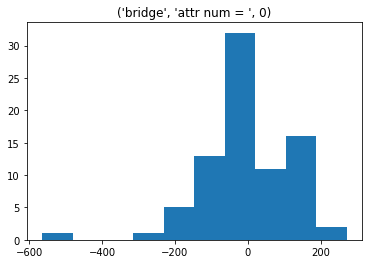

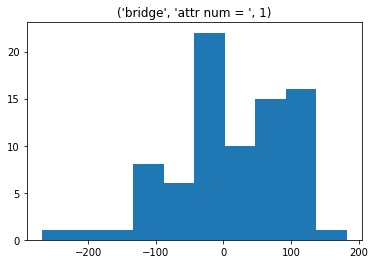

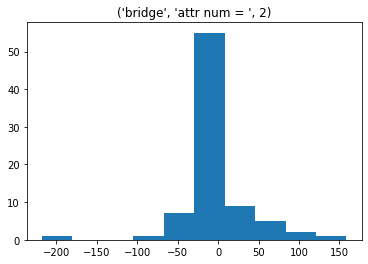

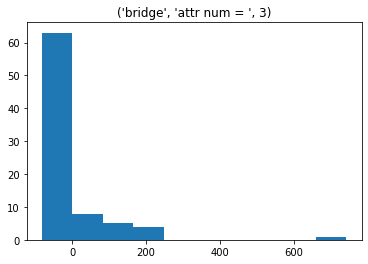

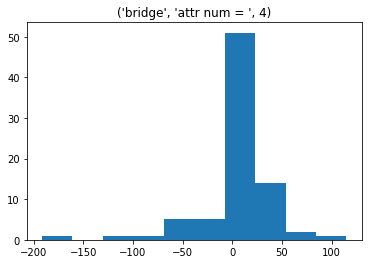

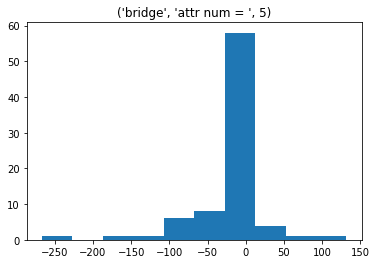

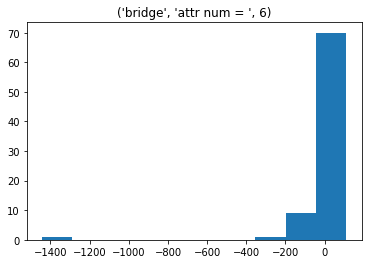

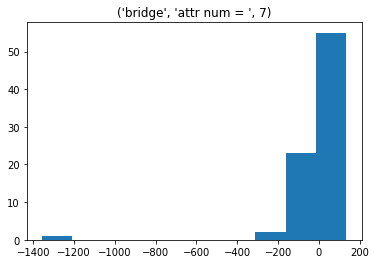

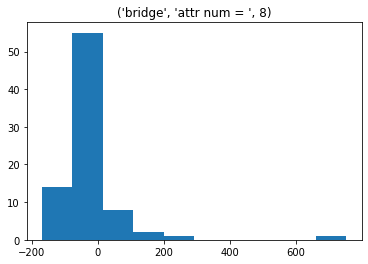

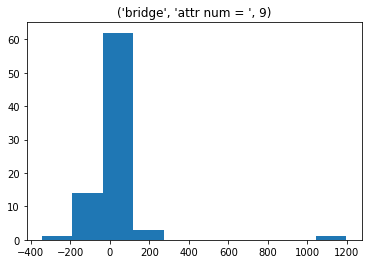

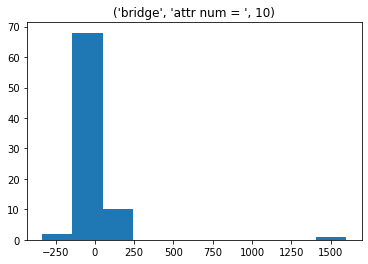

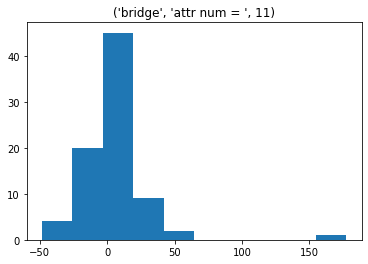

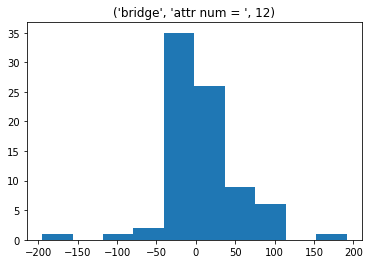

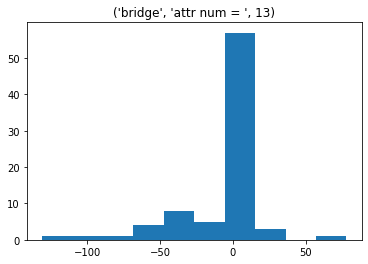

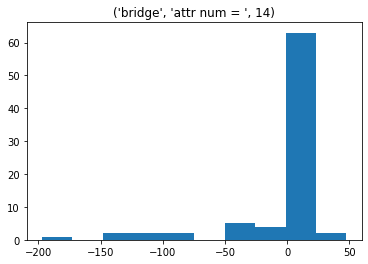

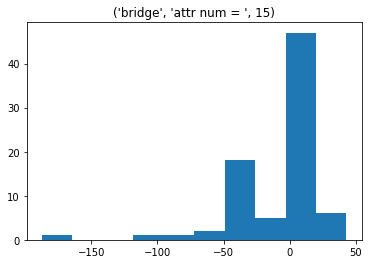

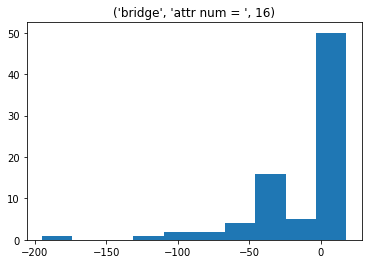

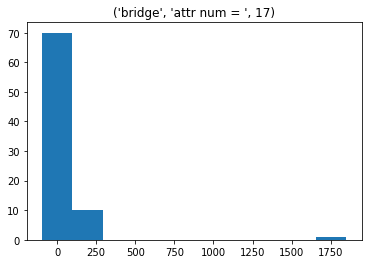

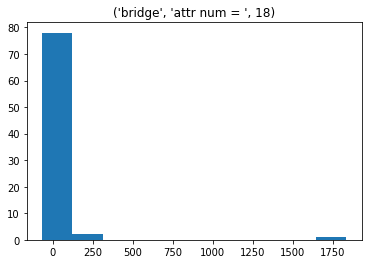

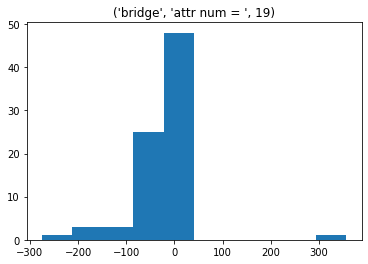

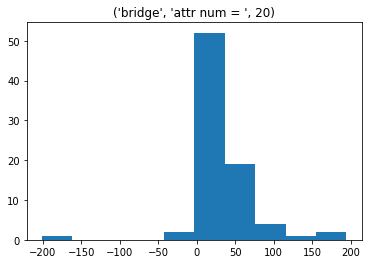

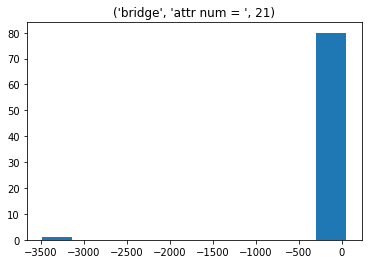

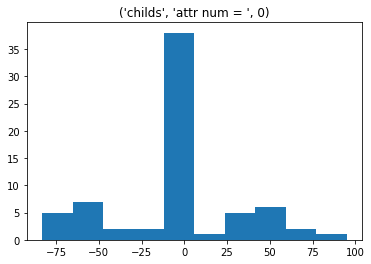

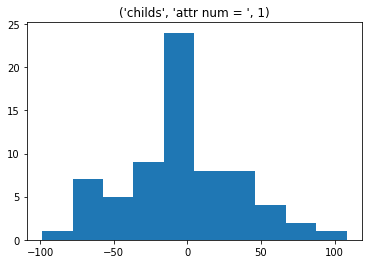

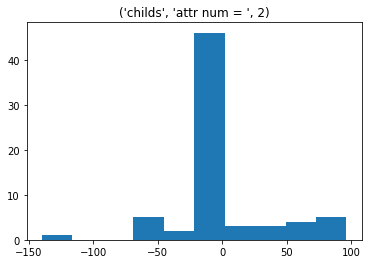

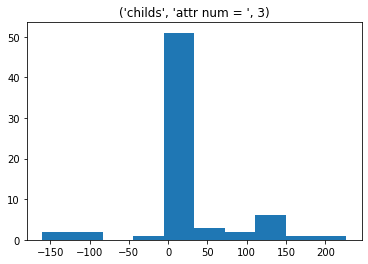

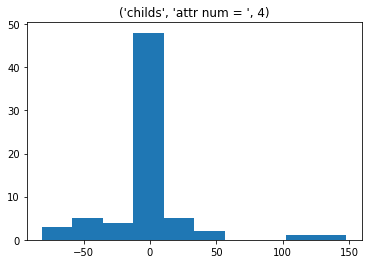

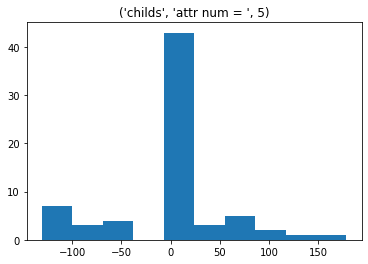

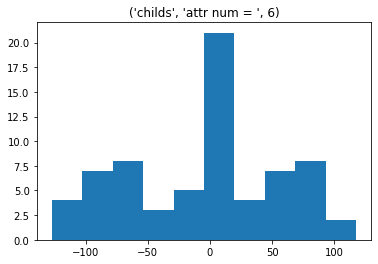

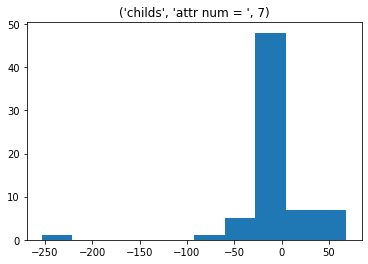

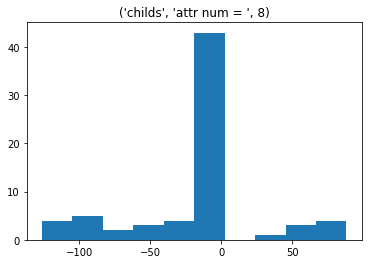

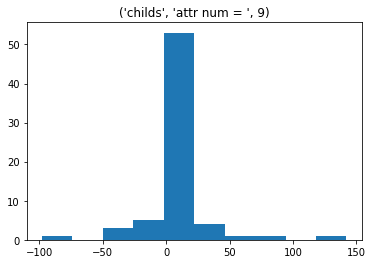

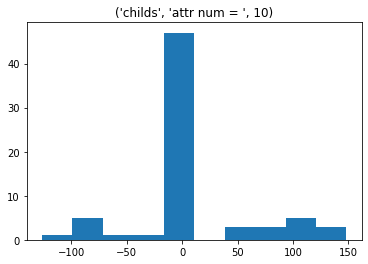

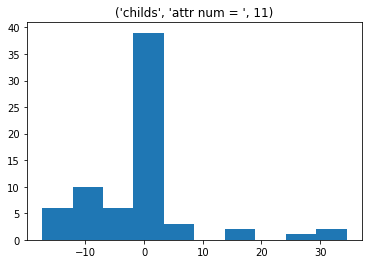

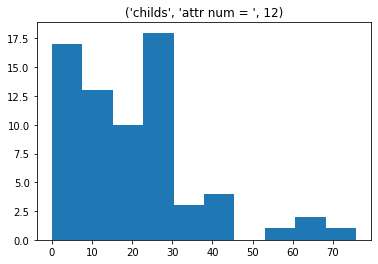

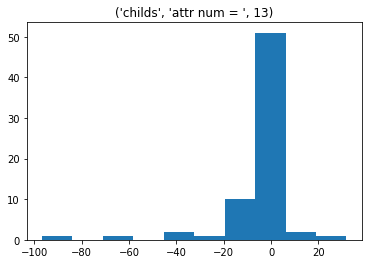

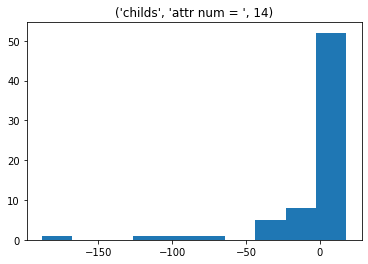

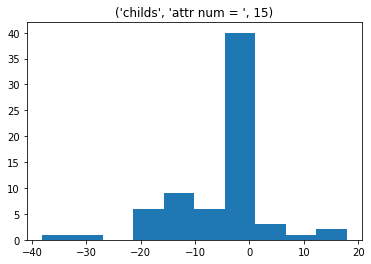

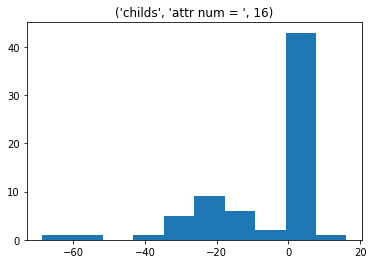

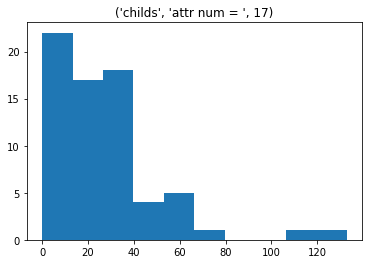

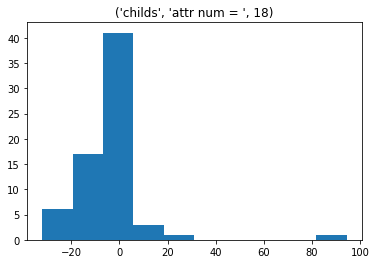

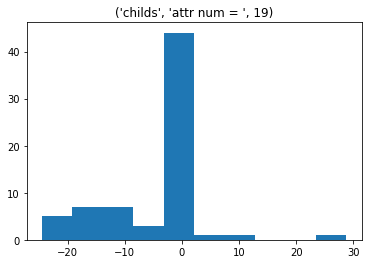

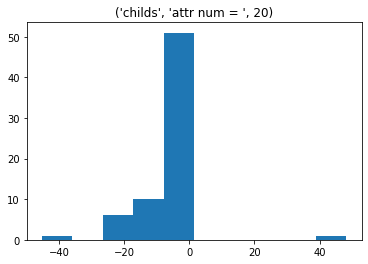

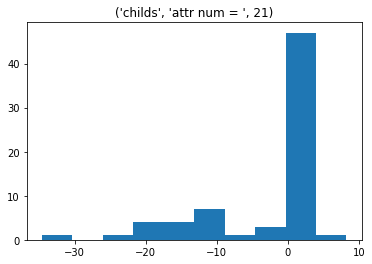

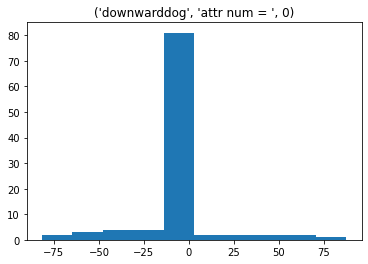

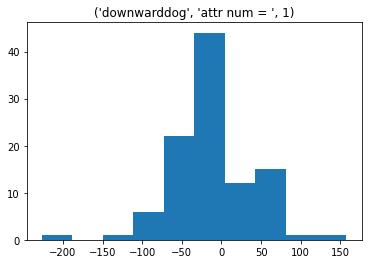

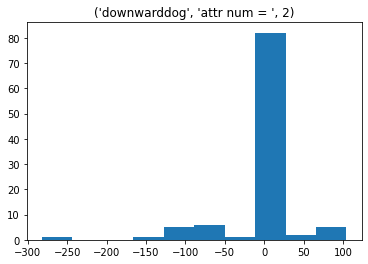

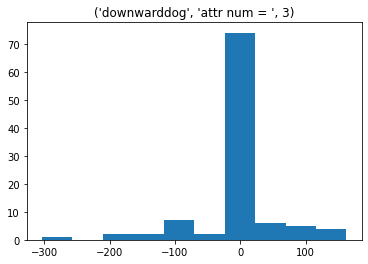

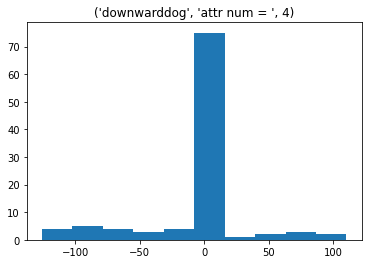

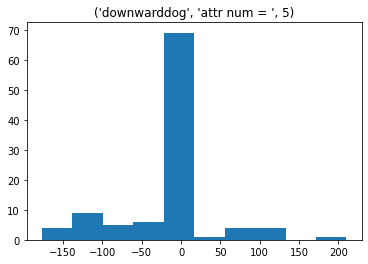

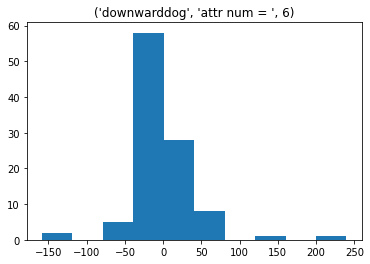

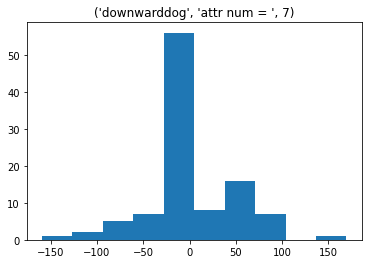

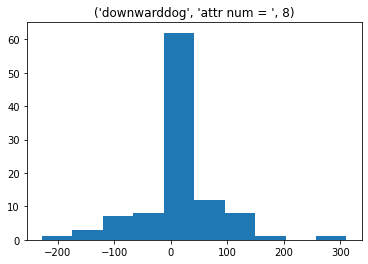

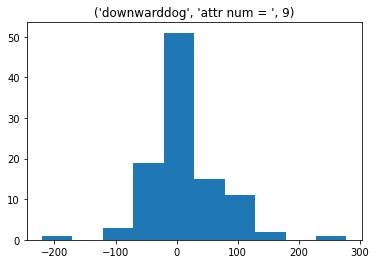

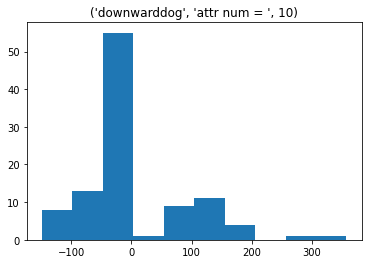

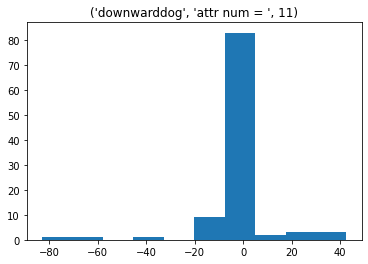

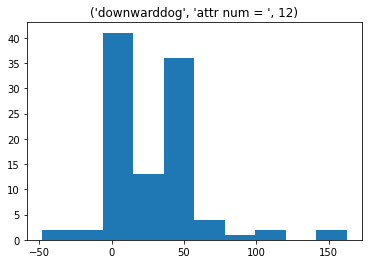

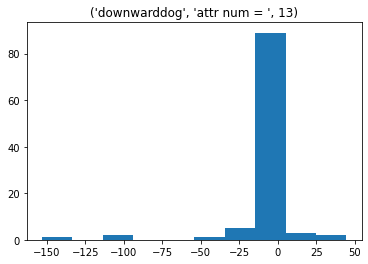

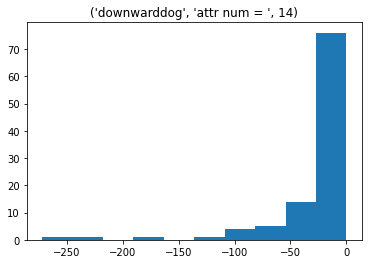

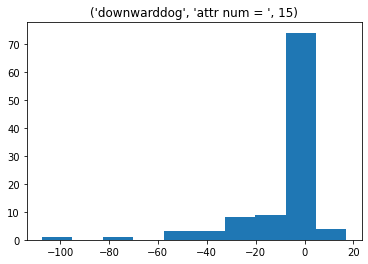

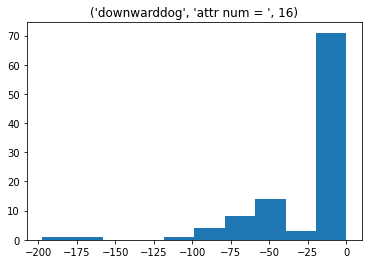

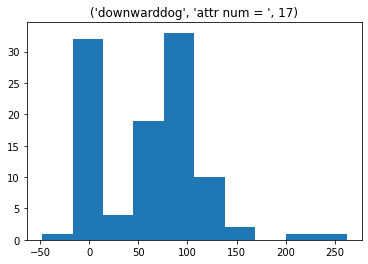

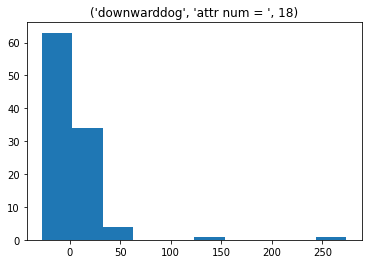

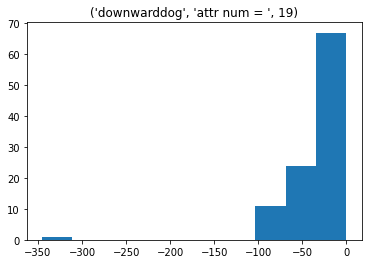

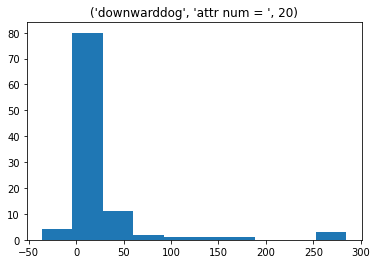

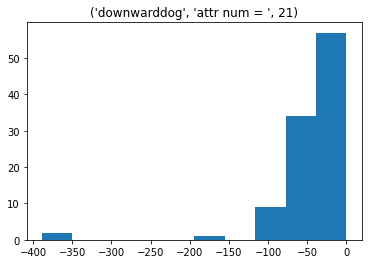

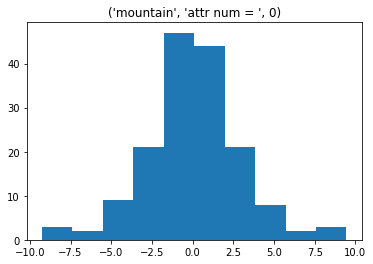

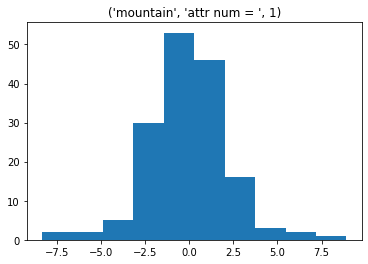

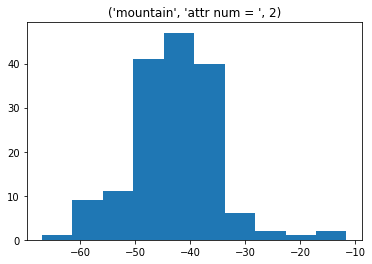

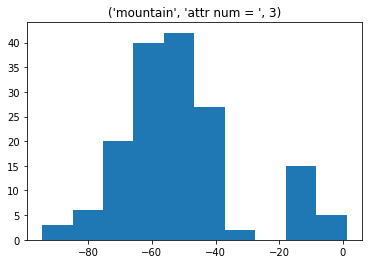

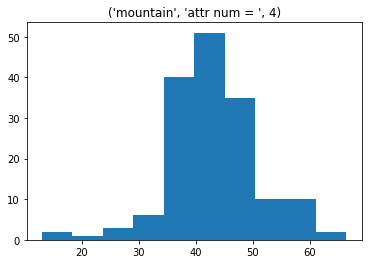

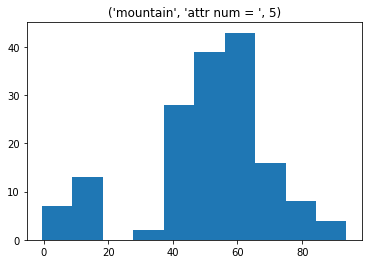

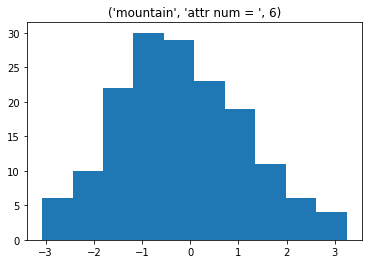

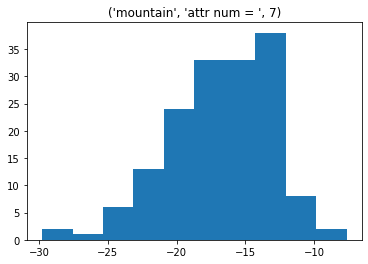

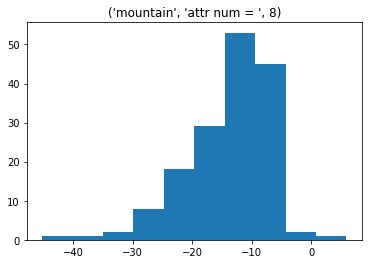

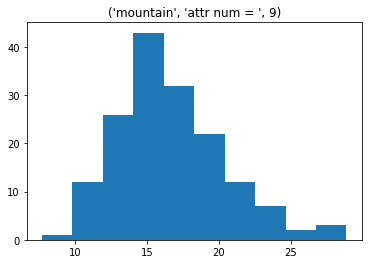

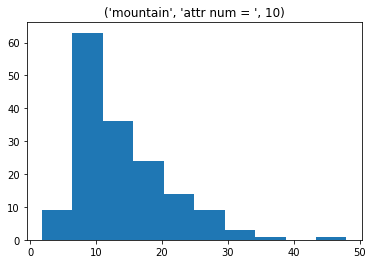

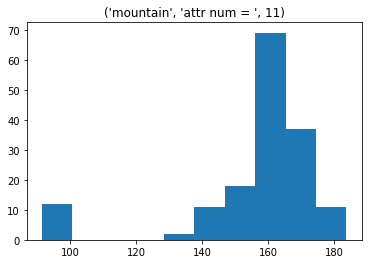

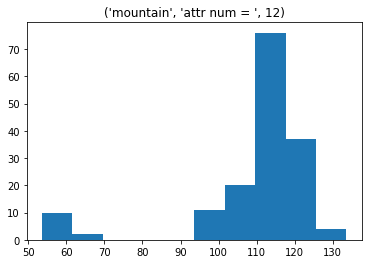

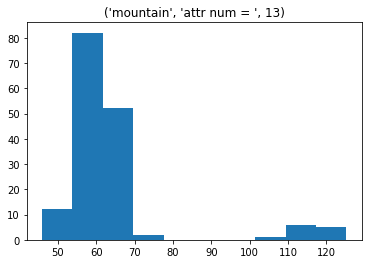

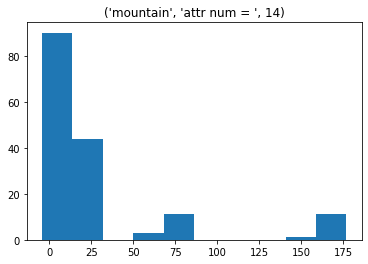

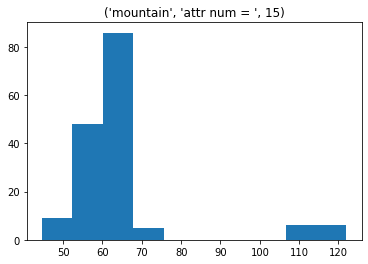

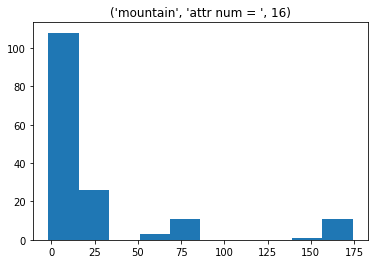

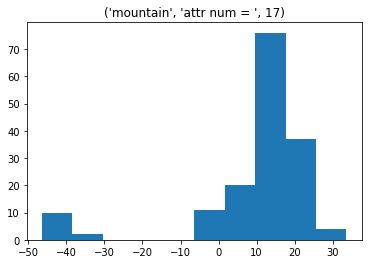

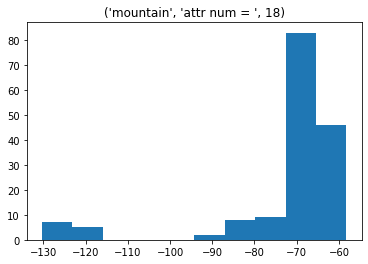

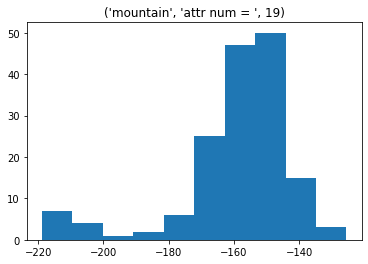

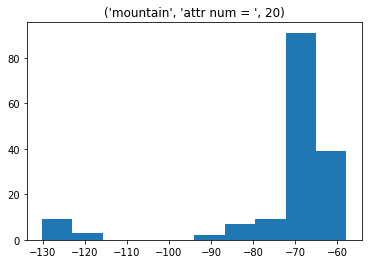

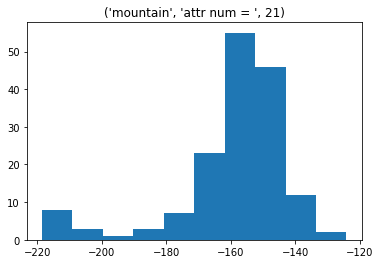

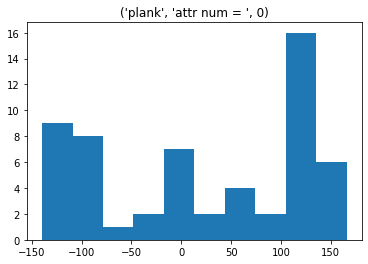

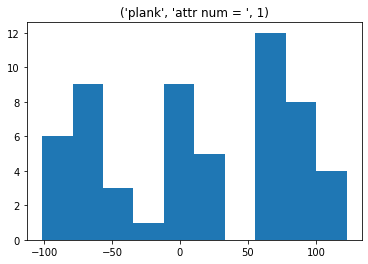

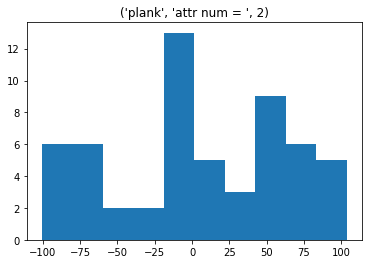

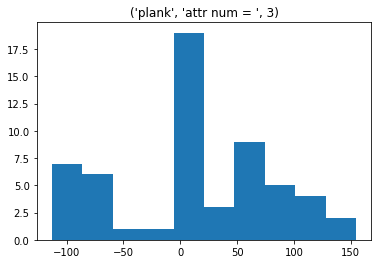

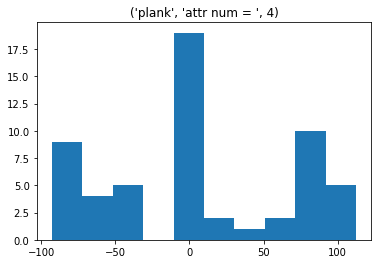

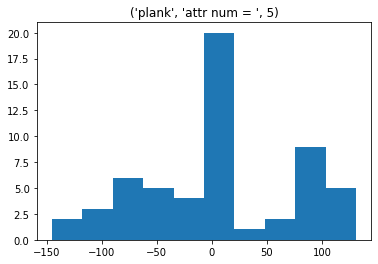

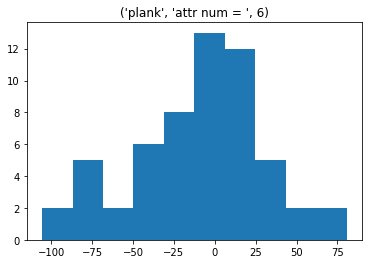

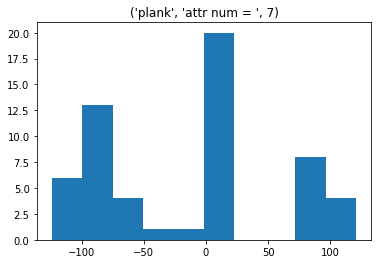

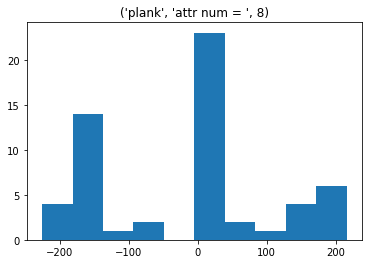

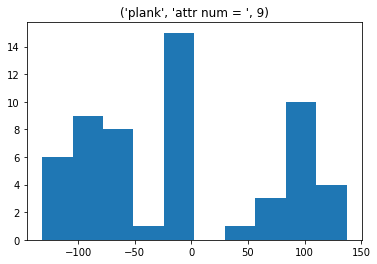

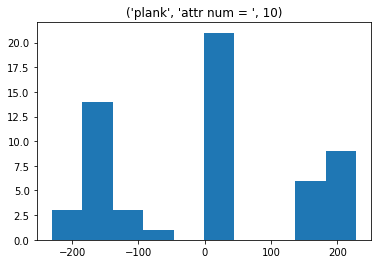

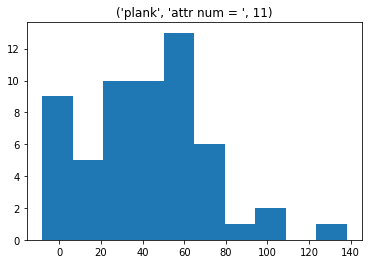

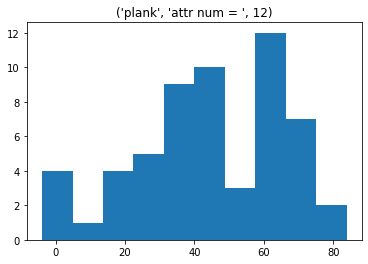

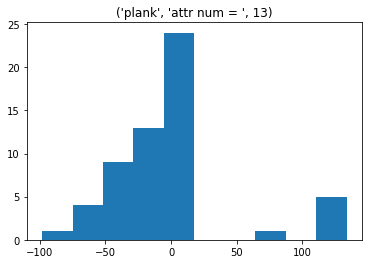

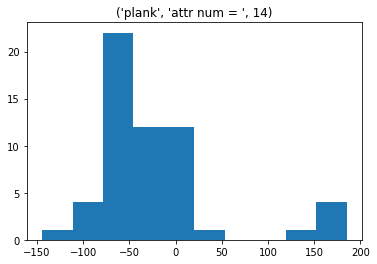

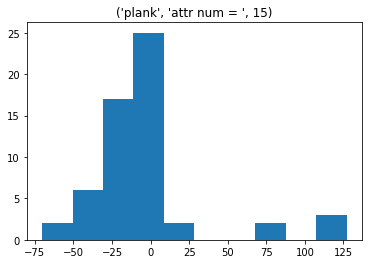

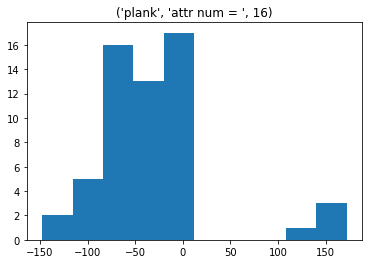

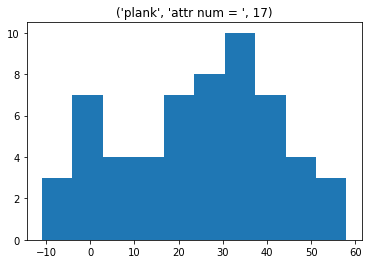

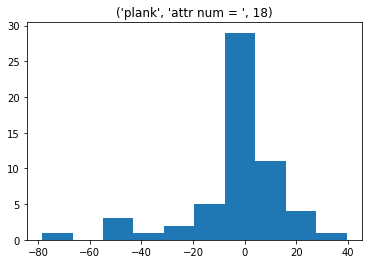

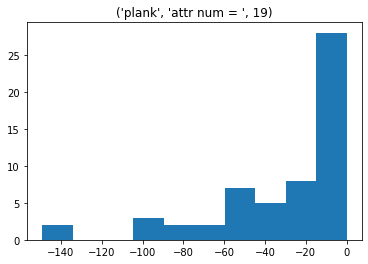

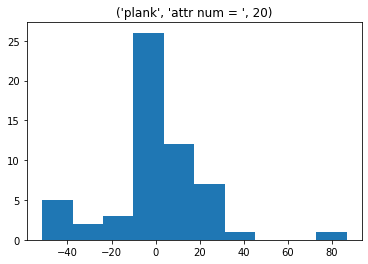

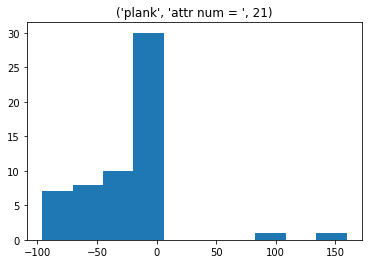

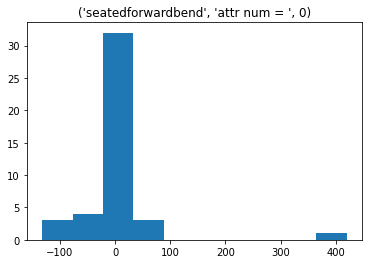

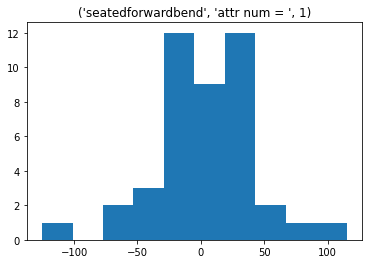

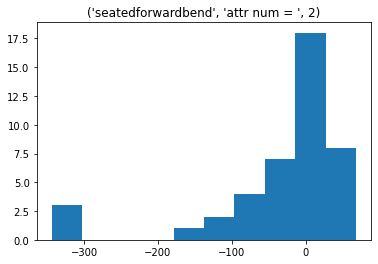

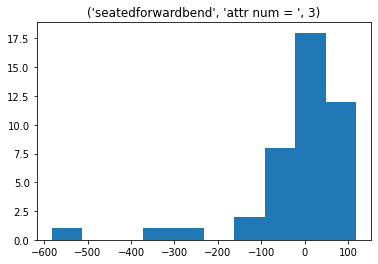

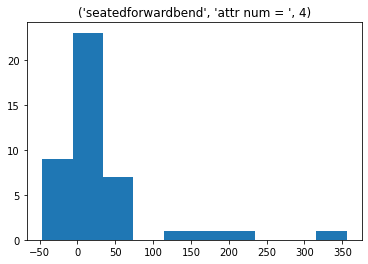

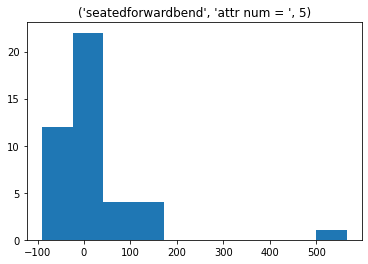

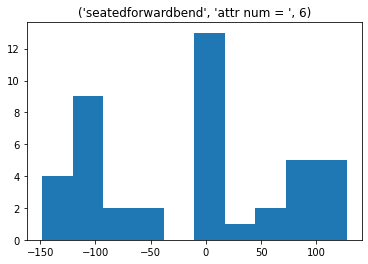

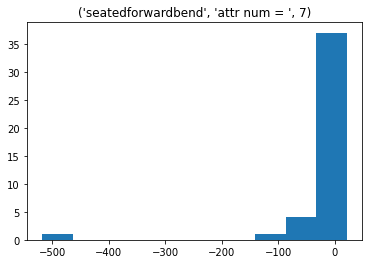

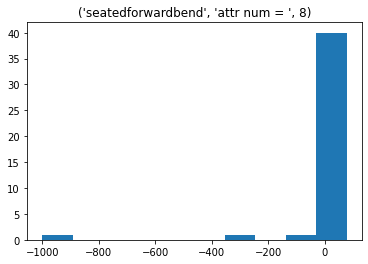

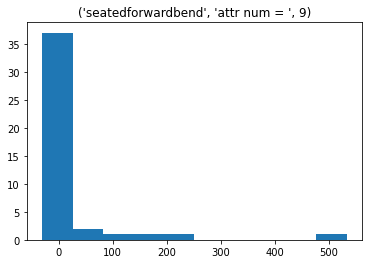

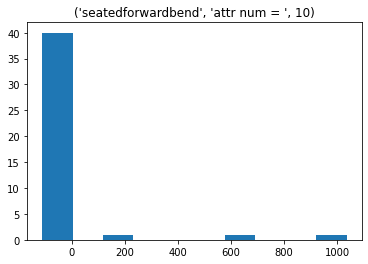

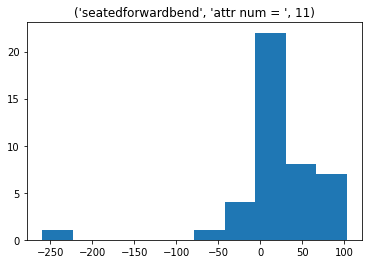

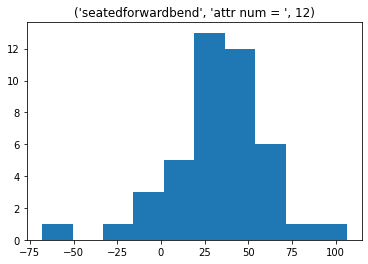

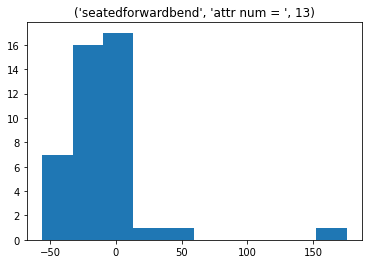

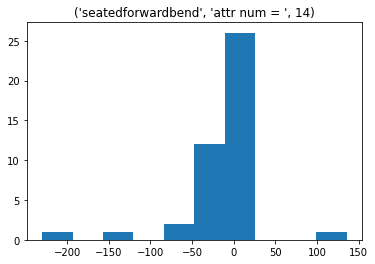

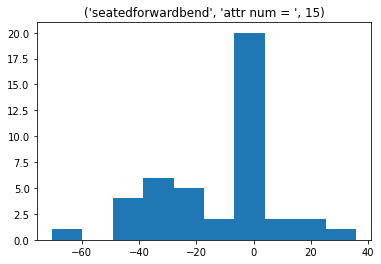

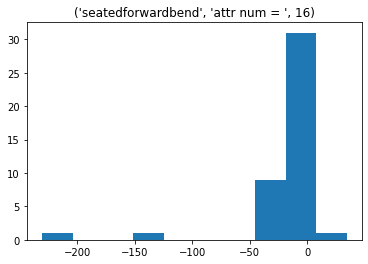

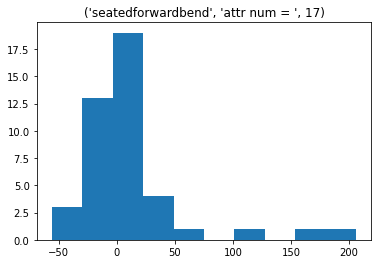

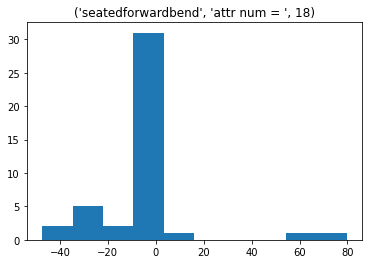

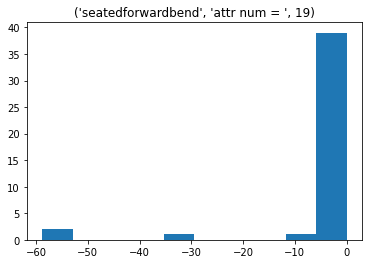

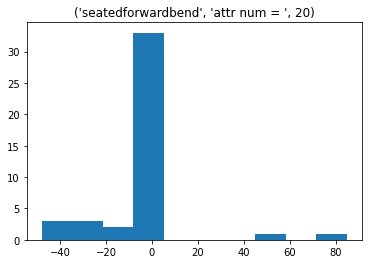

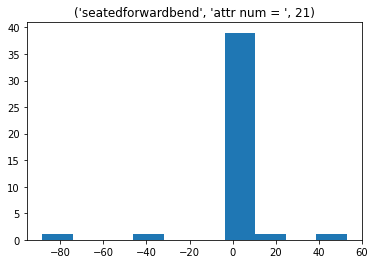

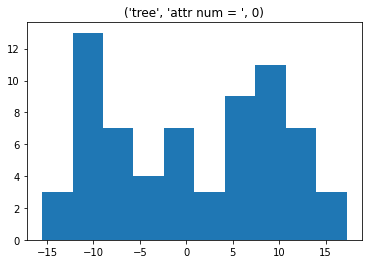

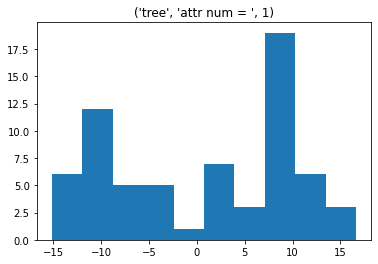

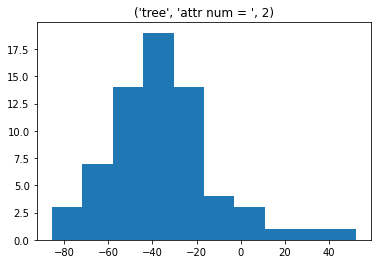

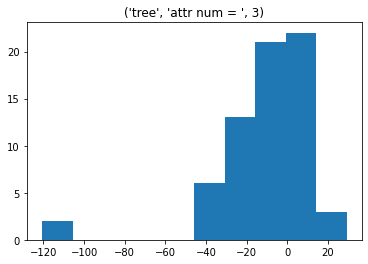

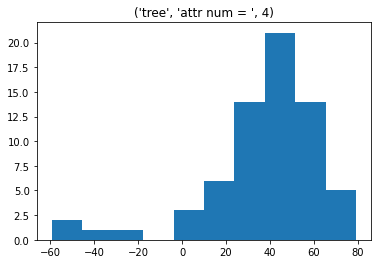

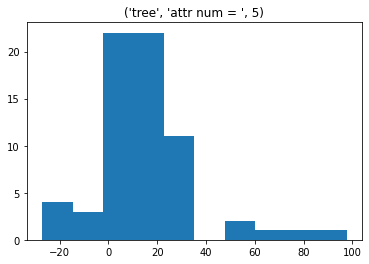

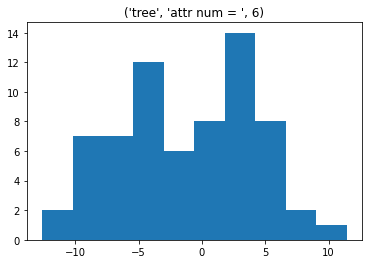

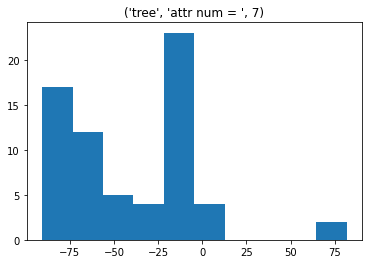

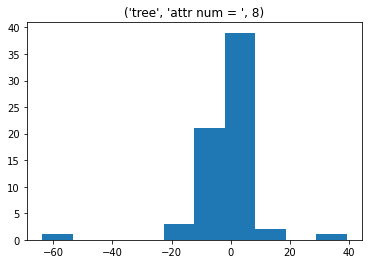

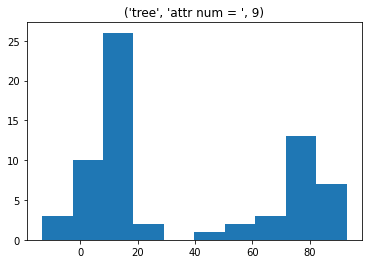

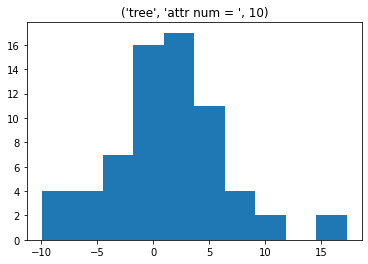

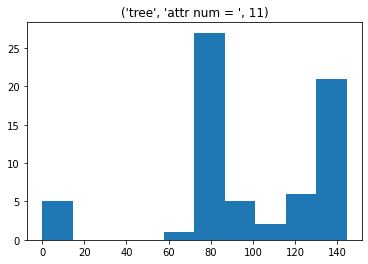

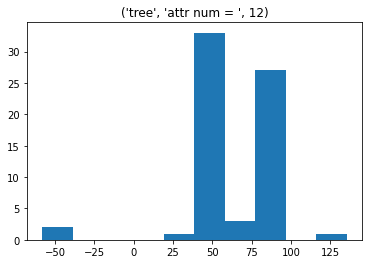

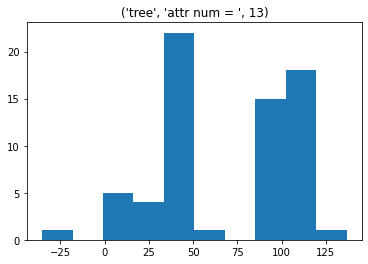

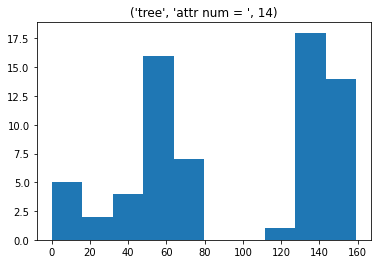

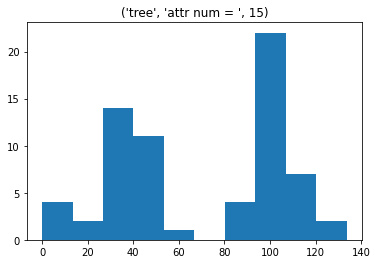

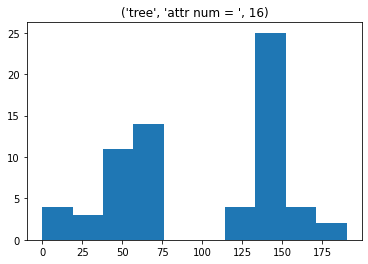

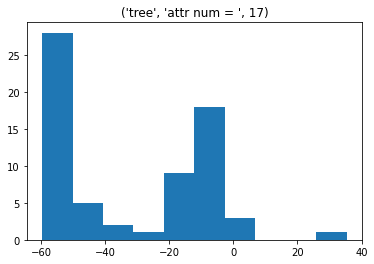

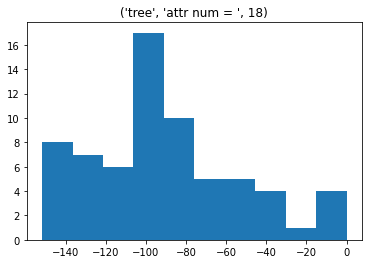

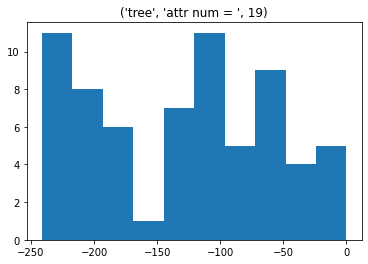

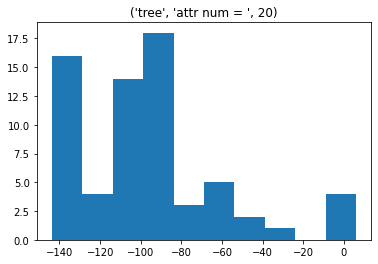

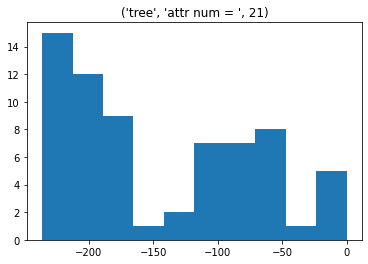

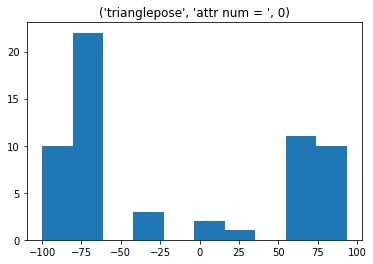

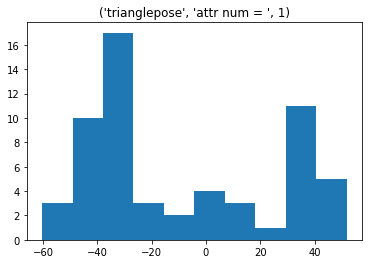

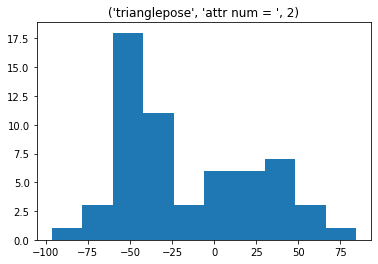

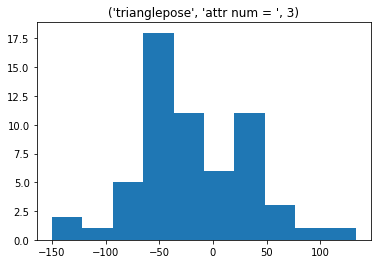

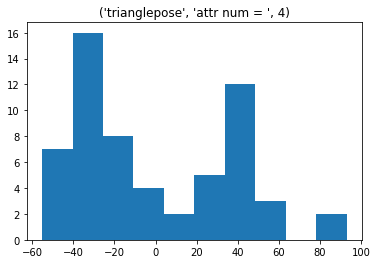

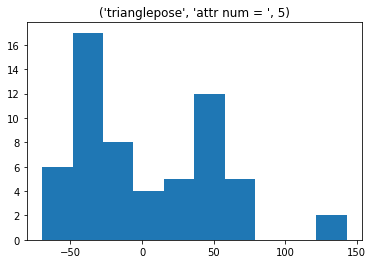

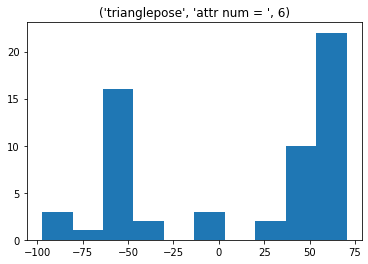

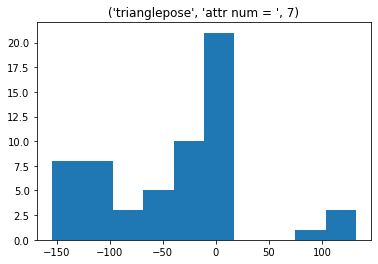

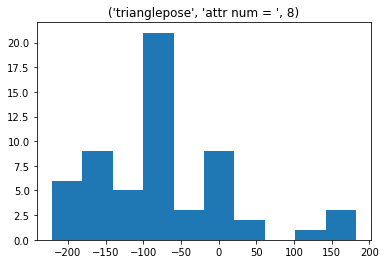

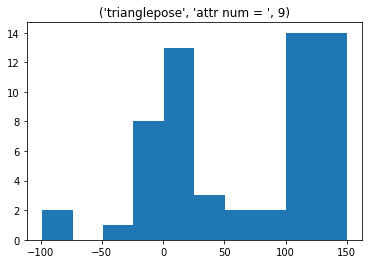

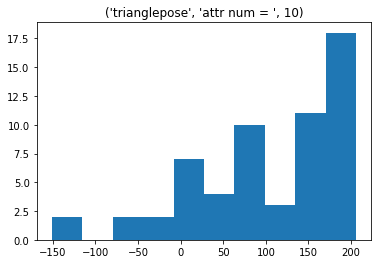

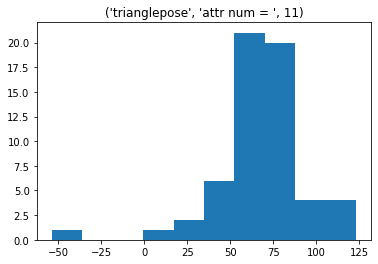

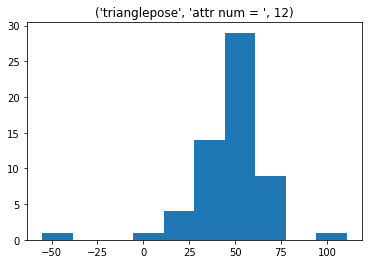

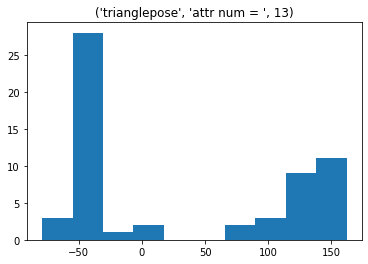

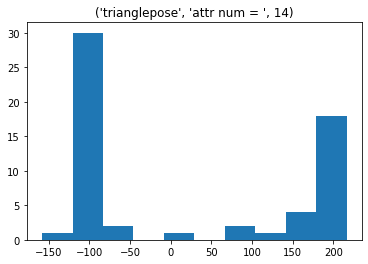

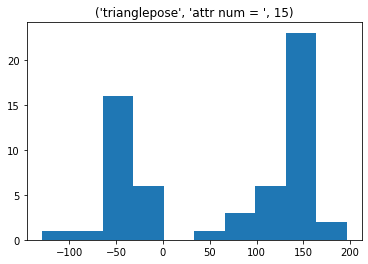

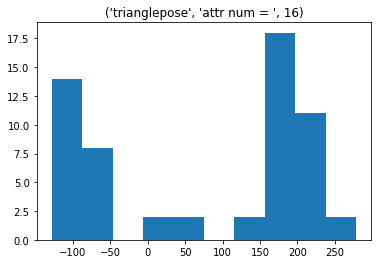

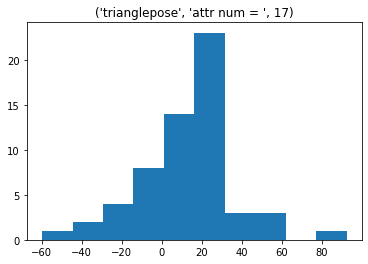

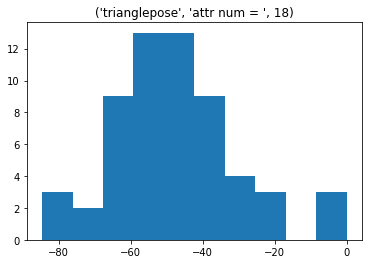

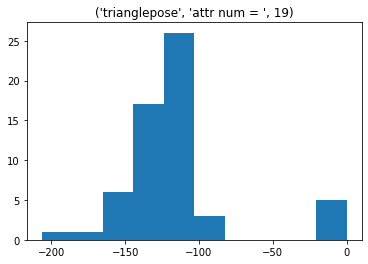

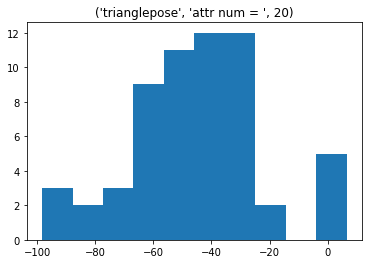

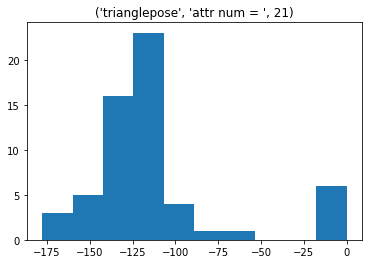

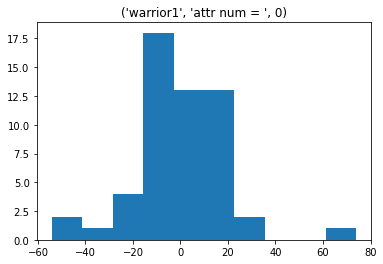

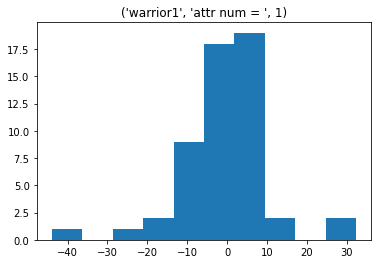

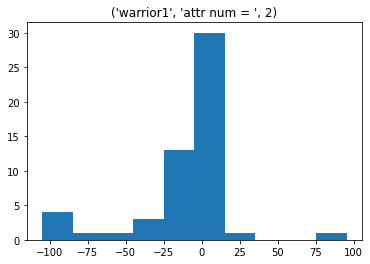

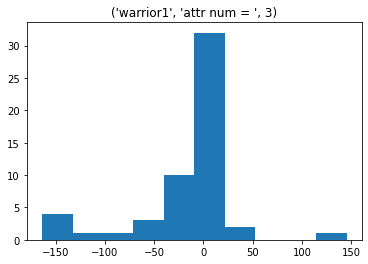

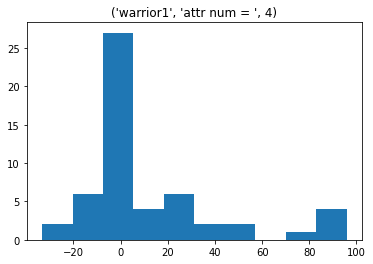

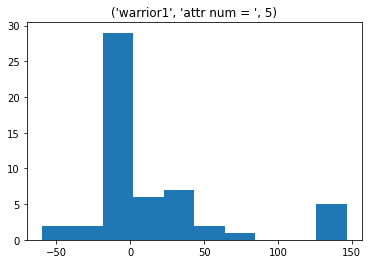

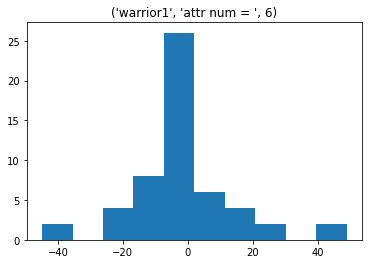

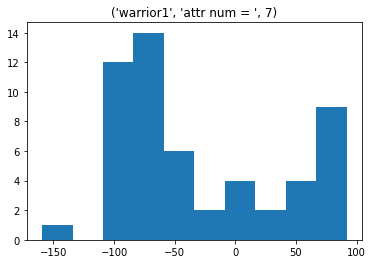

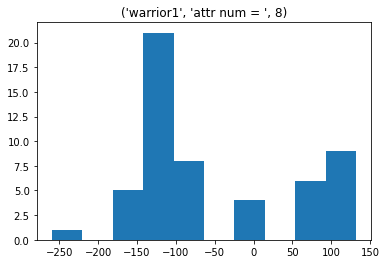

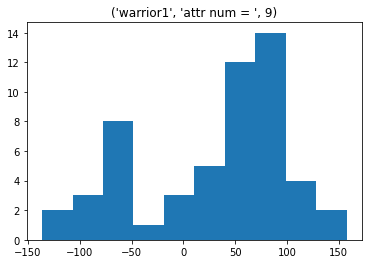

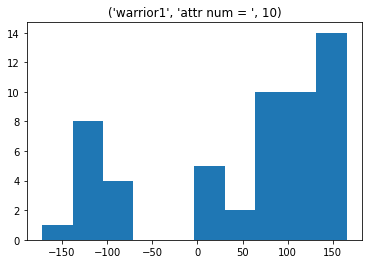

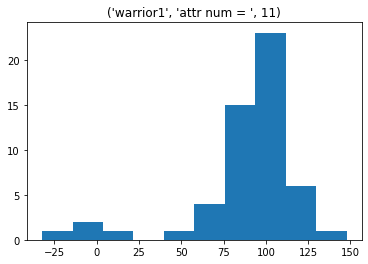

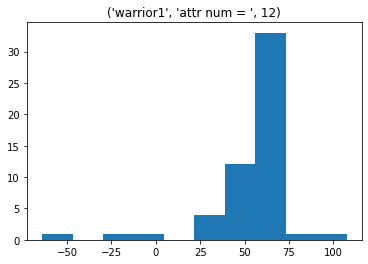

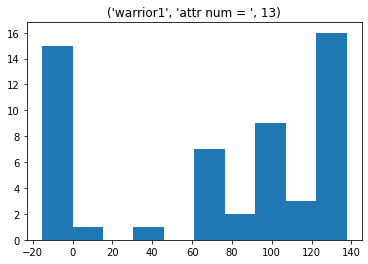

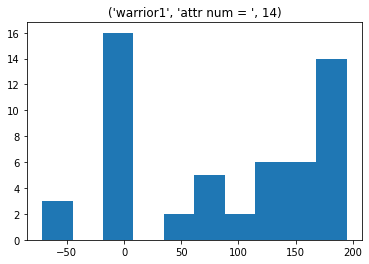

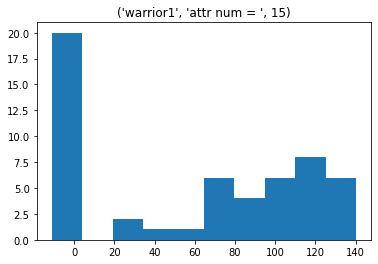

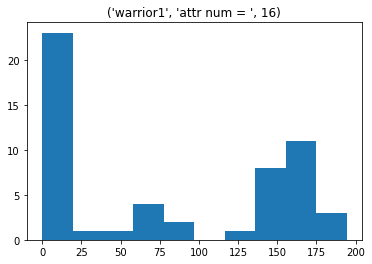

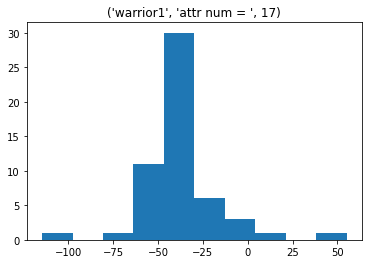

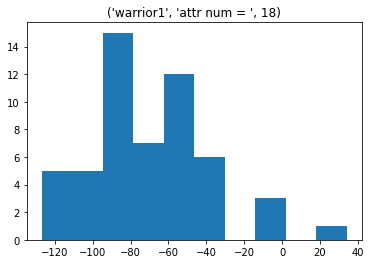

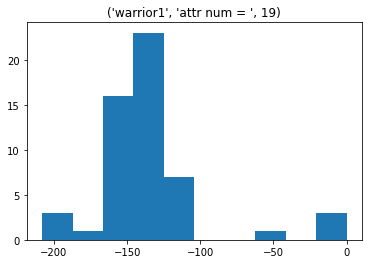

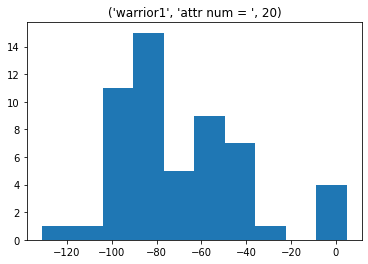

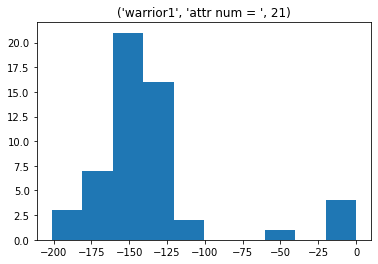

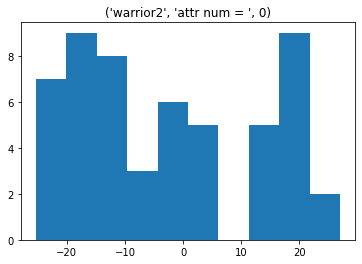

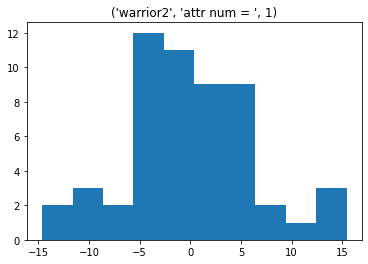

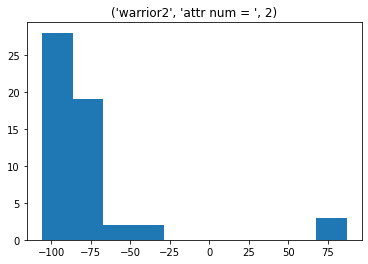

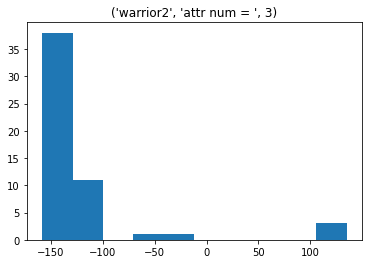

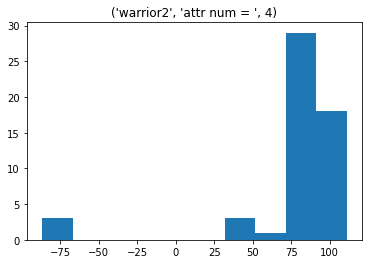

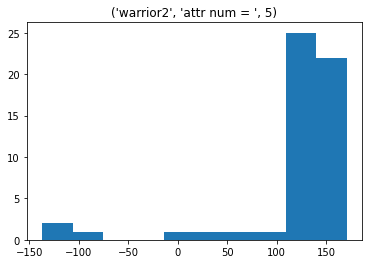

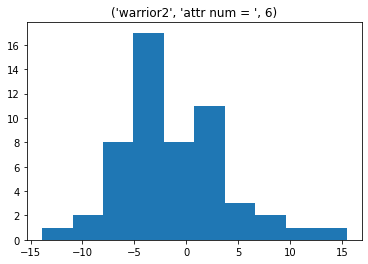

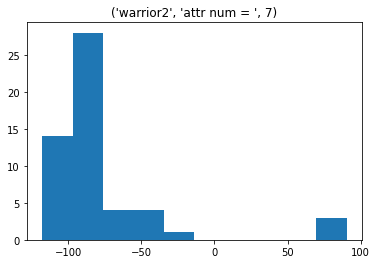

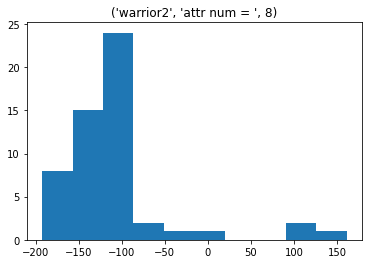

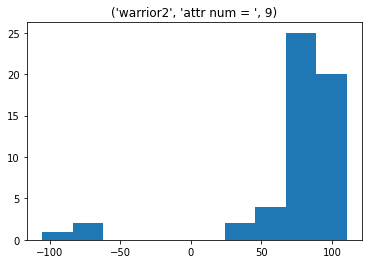

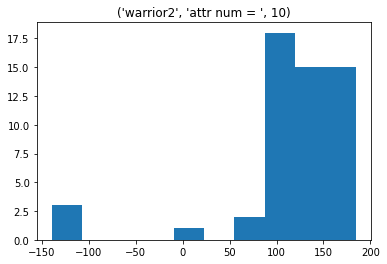

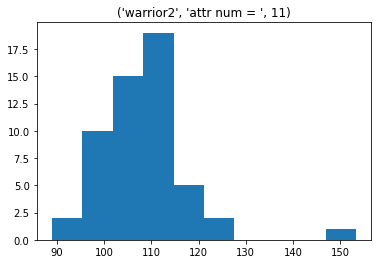

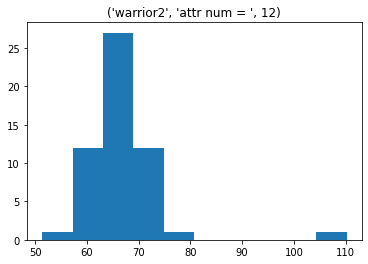

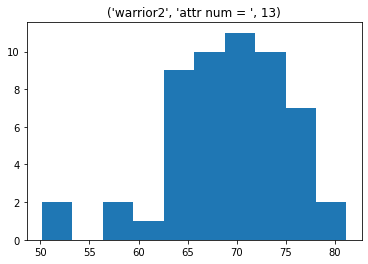

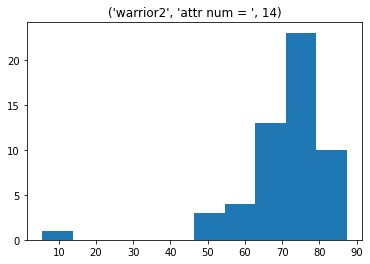

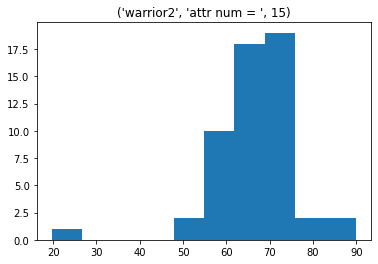

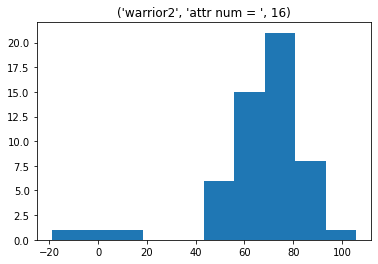

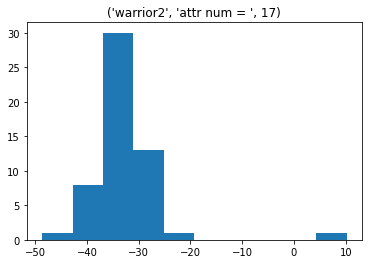

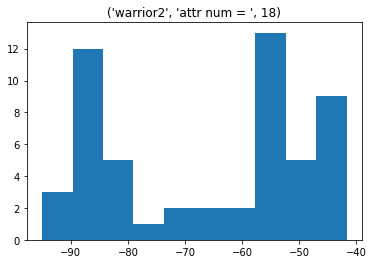

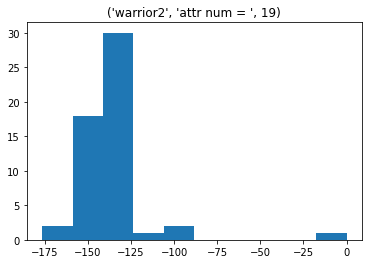

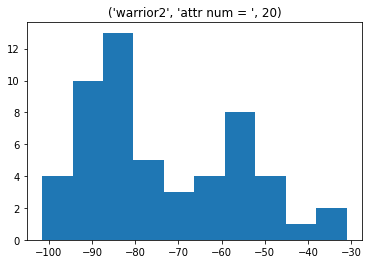

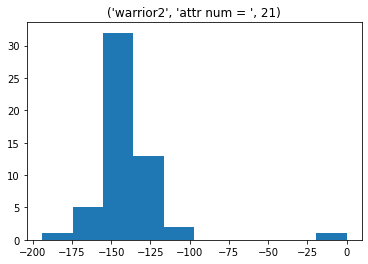

In [23]:
attribute_column = []

for keys in class_dict.keys():
    for i in range(len(class_dict[keys][0])):
        for j in range(len(class_dict[keys])):
            attribute_column.append(class_dict[keys][j][i])
        plt.hist(attribute_column)
        plt.title((keys, "attr num = ", i))
        
        plt.show()
        attribute_column = []
            
# for classes with more attributes that don't conform to gaussian distribution -> increased false positive negative numbers
# eg child and downwarddog and seatedforwardbend
# skewed due to missing values (mostly centered around zero) with spikes where it would be the mean if there were no missing values
# leads to increased false positive and false negative values because of incorrect gaussian mean and stdev used

### Q3
Implement a kernel density estimate (KDE) naive Bayes classifier and compare its performance to the Gaussian naive Bayes classifier. Recall that KDE has kernel bandwidth as a free parameter -- you can choose an arbitrary value for this, but a value in the range 5-25 is recommended. Discuss any differences you observe between the Gaussian and KDE naive Bayes classifiers. (As with the Gaussian naive Bayes, this KDE naive Bayes implementation should be your own and should not just call a pre-existing function.)

In [33]:
def KDE(kernel_bandwidth, test_instance, class_dict):
    attribute_num = len(test_instance)
    
    total_instance_n = sum([len(class_dict[key]) for key in class_dict.keys()])
    
    probs = defaultdict()
    
    for key in class_dict.keys():
        train_instances = class_dict[key]
        train_instance_num = len(class_dict[key])
        test_instance_prob = 0
        
        # for each attribute value of the test instance 
        for i in range(attribute_num):
            
            # array of one column of training datas for current attribute 
            # for example first attribute: take all the first column 
            # from all the training instance and put it in one array
            column_i = [one_train[i] for one_train in train_instances]
            
            col_i_prob = 0
       
            for j in range(len(column_i)):
                # gaussian_distribution(val,mean,std_dev)
                gaussian_kde = (gaussian_distribution(test_instance[i],column_i[j],kernel_bandwidth))
                # sum(𝜙(𝑥−𝑥i))
                col_i_prob += (gaussian_kde)
            # sum(𝜙(𝑥−𝑥i)) / num of train instance
            col_i_prob /= train_instance_num
#             print(col_i_prob)
            test_instance_prob+=take_log(col_i_prob)
        
        test_instance_prob+=take_log(len(class_dict[key])/total_instance_n)
        
        #contains all the probability of the test instance being classified as each class
        probs[key] = (test_instance_prob)

    return probs

def predict_kde():
    
    # open testing file & store data
    test_filename = "COMP30027_2021_assignment1_data/test.csv"
    open_train_file(test_attr_vals,test_actual_class,test_filename)
    str_to_float(test_attr_vals)
    remove_missing_values(test_attr_vals)
    
    predicted_classes=[]
    for instance in test_attr_vals:
        # dictionary to store the probability 
        # of each instances being classified as each classes
        probability_dict = KDE(5,instance,class_dict)
                 
        #find the class with the highest probability
        max_prob_class = max(probability_dict, key=probability_dict.get)
   
        predicted_classes.append(max_prob_class)
    
    return predicted_classes, test_actual_class

predicted, actual = predict_kde()
accuracy_kde = evaluate(actual, predicted)
# print("predicted: ",predicted)
# print("actual: ",actual)

print("KDE Accuracy is :",accuracy_kde)


76.72413793103449
KDE Accuracy is : 76.72413793103449


### Q4

Instead of using an arbitrary kernel bandwidth for the KDE naive Bayes classifier, use random hold-out or cross-validation to choose the kernel bandwidth. Discuss how this changes the model performance compared to using an arbitrary kernel bandwidth.

### Q5
Naive Bayes ignores missing values, but in pose recognition tasks the missing values can be informative. Missing values indicate that some part of the body was obscured and sometimes this is relevant to the pose (e.g., holding one hand behind the back). Are missing values useful for this task? Implement a method that incorporates information about missing values and demonstrate whether it changes the classification results.

### Q6
Engineer your own pose features from the provided keypoints. Instead of using the (x,y) positions of keypoints, you might consider the angles of the limbs or body, or the distances between pairs of keypoints. How does a naive Bayes classifier based on your engineered features compare to the classifier using (x,y) values? Please note that we are interested in explainable features for pose recognition, so simply putting the (x,y) values in a neural network or similar to get an arbitrary embedding will not receive full credit for this question. You should be able to explain the rationale behind your proposed features. Also, don't forget the conditional independence assumption of naive Bayes when proposing new features -- a large set of highly-correlated features may not work well.